# Import libraries

In [1]:
import os
import getpass
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import csv
import umap
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from itertools import product

2024-04-24 10:28:56.680275: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-24 10:28:56.742894: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-24 10:28:56.742955: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-24 10:28:56.744502: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-24 10:28:56.754277: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-24 10:28:56.755655: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
question_significance = {
    "seating_question_1": "Salt or Paprika?",
    "seating_question_2": "Which starter pokemon would you choose?",
    "seating_question_3": "Which Hogward house are you?",
    "seating_question_4": "Ideal friday evening?",
    "seating_question_5": "What's your favorite drink?",
    "seating_question_6": "What is most likely to exist?",
    "seating_question_7": "What is the best aroma?",
    "seating_question_8": "What where we talking about?",
    "seating_question_9": "What is your favoured language?",
    "seating_question_10": "Who do you prefer?",
}

weigths = {
    "seating_question_1": 0.5,
    "seating_question_2": 1,
    "seating_question_3": 2,
    "seating_question_4": 2,
    "seating_question_5": 6,
    "seating_question_6": 6,
    "seating_question_7": 4,
    "seating_question_8": 3,
    "seating_question_9": 5,
    "seating_question_10": 1,
}

In [3]:
# Function to update values
def update_values(value_counts):
    def update(x):
        count = value_counts.get(x)
        if count:
            return f"{x}-{count}"
        else:
            return x
    return update

In [4]:

server = "ec2-54-72-196-9.eu-west-1.compute.amazonaws.com"
db = "d2fect8juldk3k"
user = "puybkltrealynp"
pswd = getpass.getpass(prompt="Enter password: ")
pswd_to_enter = "10aefdea5dcd6a4366ab1e0f46cbf91366144b7a3ad7252478db2c63357fec4e"
# Set the PGPASSWORD environment variable
os.environ['PGPASSWORD'] = pswd

# Execute the PostgreSQL command without specifying the password
os.system(f"psql -h {server} -U {user} -d {db} -c 'SELECT name, email, name, family_name, has_answered_form, answer_diner, plusones, seating_question_1, seating_question_2, seating_question_3, seating_question_4, seating_question_5, seating_question_6, seating_question_7, seating_question_8, seating_question_9, seating_question_10, seating_question_11, seating_question_12, seating_question_13, seating_question_14, seating_question_15 FROM users;' -o seatings.csv")


Enter password:  ········


0

# Load complete database

In [5]:
full_csv = pd.read_csv(f"seatings.csv", delimiter="|")
# Strip leading and trailing spaces from every element in the DataFrame
full_csv = full_csv.applymap(lambda x: x.strip() if isinstance(x, str) else x)
full_csv.columns = full_csv.columns.str.strip()
full_csv = full_csv.dropna()

/tmp/ipykernel_22417/2183413473.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  full_csv = full_csv.applymap(lambda x: x.strip() if isinstance(x, str) else x)


In [6]:
full_csv['email'] = full_csv['email'].str.lower()
full_csv['email'] = full_csv['email'].str.rstrip('.')
full_csv.to_csv(f"seating_cleaned.csv")
full_csv

,name,email,name .1,family_name,has_answered_form,answer_diner,plusones,seating_question_1,seating_question_2,seating_question_3,...,seating_question_6,seating_question_7,seating_question_8,seating_question_9,seating_question_10,seating_question_11,seating_question_12,seating_question_13,seating_question_14,seating_question_15
1,Pierre,pietdel@gmail.com,Pierre,Delacroix,yes,yes,,01_paprika,02_charmander,03_gryffondor,...,06_aliens,07_pepper,08_spices,09_france,10_love_math,,,,,
2,Caroline,carolinewvh@gmail.com,Caroline,Wesselman van Helmond,yes,yes,leonore.vehmeijer@gmail.com,01_paprika,02_squirtle,03_huffelpuf,...,06_ghost,07_chocolate,08_icecream,09_unitedkingdom,10_love_math,,,,,
3,Charles-Henri,ch.starckmann@gmail.com,Charles-Henri,Starckmann,yes,yes,,01_paprika,02_squirtle,03_gryffondor,...,06_nessie,07_chocolate,08_icecream,09_france,10_love_liv,,,,,
4,Darren,darrenmk1@gmail.com,Darren,Kripaitis,yes,yes,,,,,...,,,,,,,,,,
5,Javier,javi.stauffenberg@gmail.com,Javier,Stauffenberg,no,no,,,,,...,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,Reny <3,lukitoreny@hotmail.com,Reny <3,,no,no,,,,,...,,,,,,,,,,
212,Dara,khosrowshahidara@gmail.com,Dara,Khosrowshahi,yes,yes,,01_paprika,02_squirtle,03_huffelpuf,...,06_ghost,07_pepper,08_sex,09_france,10_love_math,,,,,
213,BigNickkk,bignick@blasband.com,BigNickkk,Blasband,yes,yes,,,,,...,,,,,,,,,,
214,Tanine,tanine.daryoush@gmail.com,Tanine,,yes,no,,,,,...,,,,,,,,,,


# People who answered but answered no (to double check)

In [7]:
check = full_csv[full_csv["has_answered_form"] == "yes"]
check = check[check["answer_diner"] == "no"]
check

,name,email,name .1,family_name,has_answered_form,answer_diner,plusones,seating_question_1,seating_question_2,seating_question_3,...,seating_question_6,seating_question_7,seating_question_8,seating_question_9,seating_question_10,seating_question_11,seating_question_12,seating_question_13,seating_question_14,seating_question_15
16,Clarinette,cldursel@gmail.com,Clarinette,d'Ursel,yes,no,,,,,...,,,,,,,,,,
25,Amelie,ami@dg.com,Amelie,,yes,no,Livia,01_paprika,02_bulbasaur,03_huffelpuf,...,06_aliens,07_chocolate,08_icecream,09_unitedkingdom,10_love_liv,,,,,
33,Isaure,isauredv@gmail.com,Isaure,,yes,no,,,,,...,,,,,,,,,,
36,Olivier,odeguerre@free.fr,Olivier,,yes,no,,01_paprika,02_squirtle,03_huffelpuf,...,06_nessie,07_chocolate,08_icecream,09_france,10_love_liv,,,,,
41,Sarah,sarah.cresap.johnson@gmail.com,Sarah,Clemm,yes,no,,01_salt,02_charmander,03_ravenclaw,...,06_nessie,07_pistachio,08_icecream,09_unitedkingdom,10_love_liv,,,,,
62,Tony,adenicolay@gmail.com,Tony,de Nicolay,yes,no,,01_paprika,02_bulbasaur,03_gryffondor,...,06_god,07_vanilla,08_sex,09_france,10_love_math,,,,,
81,Edouard,e.debeauffort@gmail.com,Edouard,de Beauffort,yes,no,Ludmilla de Beauffort,,,,...,,,,,,,,,,
87,Aad,adriaanvanberckel2009@hotmail.com,Aad,,yes,no,,01_salt,02_charmander,03_gryffondor,...,06_god,07_pistachio,08_sex,,,,,,,
154,Joyce,joycevn1@gmail.com,Joyce,Van Nieuwerburgh,yes,no,,,,,...,,,,,,,,,,
160,Guix,guillaume.doultremont@gmail.com,Guix,d'Oultremont,yes,no,,,,,...,,,,,,,,,,


# Double check the plusones to include them

In [8]:
where_plus_ones = full_csv[full_csv["plusones"].str.strip() != ""][['name','email','plusones']]
where_plus_ones

,name,email,plusones
2,Caroline,carolinewvh@gmail.com,leonore.vehmeijer@gmail.com
12,Anne Sophie,annesophievv@hotmail.com,Steven Vriesendorp
15,Alice,alice.j.sommer@gmail.com,Edzi
20,Mits,julia_mens@live.nl,Jeroen van Dishoeck
21,Anastasis,aamoratis@gmail.com,Erica Efstratoudakis
25,Amelie,ami@dg.com,Livia
39,Alexander,alexsvo@me.com,Xenia Popowski
42,Léopold,leopold.gerard@gmail.com,Constance Gérard
47,Juju,jvanvolsem@gmail.com,Pietdel
52,Nabs,avanvolsem@hotmail.com,Guillain Cornet


# Load additional information

In [9]:
additional = pd.read_csv(f"important_info.csv", delimiter=",",header=0)
additional['email'] = additional['email'].str.lower()
additional['email'] = additional['email'].str.rstrip('.')
additional

,email,Sex,friend_of,table
0,victor.stinglhamber@gmail.com,male,10_mat,1.0
1,bertichat@gmail.com,male,10_mat,1.0
2,fdelimburg@gmail.com,male,10_mat,1.0
3,jdursel@gmail.com,male,10_mat,1.0
4,harold.loop@gmail.com,male,10_mat,1.0
...,...,...,...,...
219,dehemptinneb@gmail.com,male,10_parents,NaN
220,ami@dg.com,female,10_mat,NaN
221,chdelachapelle@gmail.com,male,10_parents,NaN
222,margueritesvo@me.com,female,10_parents,NaN


In [10]:
merged_total = pd.merge(full_csv, additional[['email','Sex', 'friend_of']], on='email', how='inner')
merged_total

,name,email,name .1,family_name,has_answered_form,answer_diner,plusones,seating_question_1,seating_question_2,seating_question_3,...,seating_question_8,seating_question_9,seating_question_10,seating_question_11,seating_question_12,seating_question_13,seating_question_14,seating_question_15,Sex,friend_of
0,Pierre,pietdel@gmail.com,Pierre,Delacroix,yes,yes,,01_paprika,02_charmander,03_gryffondor,...,08_spices,09_france,10_love_math,,,,,,male,10_mat
1,Caroline,carolinewvh@gmail.com,Caroline,Wesselman van Helmond,yes,yes,leonore.vehmeijer@gmail.com,01_paprika,02_squirtle,03_huffelpuf,...,08_icecream,09_unitedkingdom,10_love_math,,,,,,female,10_mat
2,Charles-Henri,ch.starckmann@gmail.com,Charles-Henri,Starckmann,yes,yes,,01_paprika,02_squirtle,03_gryffondor,...,08_icecream,09_france,10_love_liv,,,,,,male,10_mat
3,Darren,darrenmk1@gmail.com,Darren,Kripaitis,yes,yes,,,,,...,,,,,,,,,male,10_mat
4,Javier,javi.stauffenberg@gmail.com,Javier,Stauffenberg,no,no,,,,,...,,,,,,,,,male,10_mat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,Reny <3,lukitoreny@hotmail.com,Reny <3,,no,no,,,,,...,,,,,,,,,female,10_mat
212,Dara,khosrowshahidara@gmail.com,Dara,Khosrowshahi,yes,yes,,01_paprika,02_squirtle,03_huffelpuf,...,08_sex,09_france,10_love_math,,,,,,male,10_mat
213,BigNickkk,bignick@blasband.com,BigNickkk,Blasband,yes,yes,,,,,...,,,,,,,,,male,10_mat
214,Tanine,tanine.daryoush@gmail.com,Tanine,,yes,no,,,,,...,,,,,,,,,female,10_mat


# People from who we dont have information

In [11]:
merged_df = pd.merge(full_csv[['email','name']], additional[['email']], on='email', how='outer', suffixes=('_df1', '_df2'))
# Convert lists to sets
set1 = set(list(full_csv['email']))
set2 = set(list(additional['email']))

# Find elements not shared by both sets
elements_not_shared = set1.symmetric_difference(set2)
elements_not_shared

{'alexis.philippartdefoy@gmail.com',
 'alexis.phillipartdefoy@gmail.com',
 'denicolaytatiana@gmail.com',
 'elenaderibaucourt@gmail.com',
 'louisdebrouwer@hotmail.com',
 'ludmilladepotter@gmail.com',
 'pdormesson@gmail.com',
 'plusone_phillipe',
 'tom.cartuyvels@hotmail.com'}

In [12]:
emails_list = list(elements_not_shared)
# Specify the CSV file path
csv_file_path = "not_shared.csv"

# Write list to CSV file
with open(csv_file_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['email'])  # Write header
    writer.writerows([[email] for email in emails_list])

# People who answered the form but didnt do the table seating game

In [13]:
answered_invitation_but_didnt_play = full_csv[full_csv['has_answered_form'] == 'yes']
answered_invitation_but_didnt_play = answered_invitation_but_didnt_play[answered_invitation_but_didnt_play["seating_question_1"].str.strip() == ""]
answered_invitation_but_didnt_play

,name,email,name .1,family_name,has_answered_form,answer_diner,plusones,seating_question_1,seating_question_2,seating_question_3,...,seating_question_6,seating_question_7,seating_question_8,seating_question_9,seating_question_10,seating_question_11,seating_question_12,seating_question_13,seating_question_14,seating_question_15
4,Darren,darrenmk1@gmail.com,Darren,Kripaitis,yes,yes,,,,,...,,,,,,,,,,
8,Mams,azinedeh@gmail.com,Mams,de Hemptinne,yes,yes,,,,,...,,,,,,,,,,
16,Clarinette,cldursel@gmail.com,Clarinette,d'Ursel,yes,no,,,,,...,,,,,,,,,,
33,Isaure,isauredv@gmail.com,Isaure,,yes,no,,,,,...,,,,,,,,,,
61,Sunshine,alexr89@hotmail.fr,Sunshine,Renie,yes,yes,,,,,...,,,,,,,,,,
81,Edouard,e.debeauffort@gmail.com,Edouard,de Beauffort,yes,no,Ludmilla de Beauffort,,,,...,,,,,,,,,,
108,Anne Katharina,a.k.greul@gmail.com,Anne Katharina,Greul,yes,yes,,,,,...,,,,,,,,,,
154,Joyce,joycevn1@gmail.com,Joyce,Van Nieuwerburgh,yes,no,,,,,...,,,,,,,,,,
160,Guix,guillaume.doultremont@gmail.com,Guix,d'Oultremont,yes,no,,,,,...,,,,,,,,,,
213,BigNickkk,bignick@blasband.com,BigNickkk,Blasband,yes,yes,,,,,...,,,,,,,,,,


# All people who at least started the table seating game

In [14]:
only_answered = merged_total[merged_total["seating_question_1"].str.strip() != ""]
only_answered

,name,email,name .1,family_name,has_answered_form,answer_diner,plusones,seating_question_1,seating_question_2,seating_question_3,...,seating_question_8,seating_question_9,seating_question_10,seating_question_11,seating_question_12,seating_question_13,seating_question_14,seating_question_15,Sex,friend_of
0,Pierre,pietdel@gmail.com,Pierre,Delacroix,yes,yes,,01_paprika,02_charmander,03_gryffondor,...,08_spices,09_france,10_love_math,,,,,,male,10_mat
1,Caroline,carolinewvh@gmail.com,Caroline,Wesselman van Helmond,yes,yes,leonore.vehmeijer@gmail.com,01_paprika,02_squirtle,03_huffelpuf,...,08_icecream,09_unitedkingdom,10_love_math,,,,,,female,10_mat
2,Charles-Henri,ch.starckmann@gmail.com,Charles-Henri,Starckmann,yes,yes,,01_paprika,02_squirtle,03_gryffondor,...,08_icecream,09_france,10_love_liv,,,,,,male,10_mat
5,Chachaa,vandenbulcke.cha@gmail.com,Chachaa,Van den Bulcke,yes,yes,,01_paprika,02_charmander,03_ravenclaw,...,08_icecream,09_france,10_love_liv,,,,,,female,10_liv
6,Crackold,harold.delacroix@gmail.com,Crackold,Delacroix,yes,yes,,01_paprika,02_bulbasaur,03_huffelpuf,...,08_spices,09_france,10_love_liv,,,,,,male,10_mat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,Aline Tatiana,alinefadie@gmail.com,Aline Tatiana,Fadié,yes,yes,,01_salt,02_charmander,03_slitherin,...,08_icecream,09_france,10_love_math,,,,,,female,10_mat
206,Emily,emily.vanwassenhove@gmail.com,Emily,,yes,yes,,01_salt,02_charmander,03_gryffondor,...,08_icecream,09_france,10_love_liv,,,,,,female,10_mat
209,Eugénie,eugenie_stinglhamber@hotmail.com,Eugénie,Stinglhamber,yes,yes,,01_salt,02_bulbasaur,03_huffelpuf,...,08_sex,09_france,10_love_liv,,,,,,female,10_mat
210,Victor,victor.stinglhamber@gmail.com,Victor,Stinglhamber,yes,yes,,01_paprika,02_charmander,03_slitherin,...,08_spices,09_france,10_love_liv,,,,,,male,10_mat


# Weird group who played but answered no for dinner

In [15]:
weird_group = only_answered[only_answered["answer_diner"] == "no"]
weird_group

,name,email,name .1,family_name,has_answered_form,answer_diner,plusones,seating_question_1,seating_question_2,seating_question_3,...,seating_question_8,seating_question_9,seating_question_10,seating_question_11,seating_question_12,seating_question_13,seating_question_14,seating_question_15,Sex,friend_of
24,Amelie,ami@dg.com,Amelie,,yes,no,Livia,01_paprika,02_bulbasaur,03_huffelpuf,...,08_icecream,09_unitedkingdom,10_love_liv,,,,,,female,10_mat
34,Olivier,odeguerre@free.fr,Olivier,,yes,no,,01_paprika,02_squirtle,03_huffelpuf,...,08_icecream,09_france,10_love_liv,,,,,,male,10_parents
39,Sarah,sarah.cresap.johnson@gmail.com,Sarah,Clemm,yes,no,,01_salt,02_charmander,03_ravenclaw,...,08_icecream,09_unitedkingdom,10_love_liv,,,,,,female,10_liv
60,Tony,adenicolay@gmail.com,Tony,de Nicolay,yes,no,,01_paprika,02_bulbasaur,03_gryffondor,...,08_sex,09_france,10_love_math,,,,,,male,10_mat
85,Aad,adriaanvanberckel2009@hotmail.com,Aad,,yes,no,,01_salt,02_charmander,03_gryffondor,...,08_sex,,,,,,,,male,10_liv
127,Toutia,toutia.daryoush@gmail.com,Toutia,Daryoush,no,no,,01_salt,02_charmander,03_ravenclaw,...,08_icecream,09_unitedkingdom,10_love_liv,,,,,,female,10_mat
163,Gaspar,gdursel@gmail.com,Gaspar,d'Ursel,yes,no,,01_salt,02_charmander,03_gryffondor,...,08_spices,09_unitedkingdom,10_love_liv,,,,,,male,10_mat
169,Papili,thdeguerre@gmail.com,Papili,de Guerre,yes,no,anastasiadeguerre@gmail.com,01_salt,02_bulbasaur,03_gryffondor,...,08_sex,09_france,10_love_liv,,,,,,male,10_parents


In [16]:
len(only_answered)

117

# Filtering out parents

In [17]:
only_answered = only_answered[only_answered["friend_of"]!="10_parents"]

# Filtering out those who said no to the diner

In [18]:
only_answered = only_answered[only_answered["answer_diner"]!="no"]

# Double checking one last time plusones

In [19]:
where_plus_ones = only_answered[only_answered["plusones"].str.strip() != ""][['name','email','plusones']]
where_plus_ones

,name,email,plusones
1,Caroline,carolinewvh@gmail.com,leonore.vehmeijer@gmail.com
11,Anne Sophie,annesophievv@hotmail.com,Steven Vriesendorp
14,Alice,alice.j.sommer@gmail.com,Edzi
19,Mits,julia_mens@live.nl,Jeroen van Dishoeck
20,Anastasis,aamoratis@gmail.com,Erica Efstratoudakis
37,Alexander,alexsvo@me.com,Xenia Popowski
40,Léopold,leopold.gerard@gmail.com,Constance Gérard
45,Juju,jvanvolsem@gmail.com,Pietdel
50,Nabs,avanvolsem@hotmail.com,Guillain Cornet
53,Erica,erica.efst@gmail.com,Anastasis Amoratis


# Only seating questions to encode

In [20]:
only_seating_colls = only_answered[["friend_of","seating_question_1","seating_question_2","seating_question_3","seating_question_4","seating_question_5","seating_question_6","seating_question_7","seating_question_8","seating_question_9","seating_question_10"]]
only_seating_colls = only_seating_colls.applymap(lambda x: str(x).split('_')[-1])
only_seating_colls.replace(r'^\s*$', "no answer", regex=True, inplace=True)
only_seating_colls

/tmp/ipykernel_22417/3761749874.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  only_seating_colls = only_seating_colls.applymap(lambda x: str(x).split('_')[-1])


,friend_of,seating_question_1,seating_question_2,seating_question_3,seating_question_4,seating_question_5,seating_question_6,seating_question_7,seating_question_8,seating_question_9,seating_question_10
0,mat,paprika,charmander,gryffondor,browncafe,wine,aliens,pepper,spices,france,math
1,mat,paprika,squirtle,huffelpuf,clubbing,tea,ghost,chocolate,icecream,unitedkingdom,math
2,mat,paprika,squirtle,gryffondor,browncafe,beer,nessie,chocolate,icecream,france,liv
5,liv,paprika,charmander,ravenclaw,browncafe,coffee,nessie,chocolate,icecream,france,liv
6,mat,paprika,bulbasaur,huffelpuf,browncafe,gin,nessie,pepper,spices,france,liv
...,...,...,...,...,...,...,...,...,...,...,...
205,mat,salt,charmander,slitherin,clubbing,coffee,ghost,chocolate,icecream,france,math
206,mat,salt,charmander,gryffondor,clubbing,gin,god,chocolate,icecream,france,liv
209,mat,salt,bulbasaur,huffelpuf,browncafe,beer,aliens,pistachio,sex,france,liv
210,mat,paprika,charmander,slitherin,browncafe,wine,aliens,chocolate,spices,france,liv


In [21]:
mask = (only_seating_colls == "no answer").any(axis=1)
temp = only_answered[['name','email']]
temp = pd.concat([temp, only_seating_colls], axis = 1)
not_finished_answering = temp[mask]
not_finished_answering

,name,email,friend_of,seating_question_1,seating_question_2,seating_question_3,seating_question_4,seating_question_5,seating_question_6,seating_question_7,seating_question_8,seating_question_9,seating_question_10
91,Molly,ohman.molly@gmail.com,liv,salt,no answer,no answer,no answer,no answer,no answer,no answer,no answer,no answer,no answer


In [22]:
filtered_df = only_seating_colls[~mask]
needed_later = only_answered
needed_later = needed_later[~mask]
filtered_df

,friend_of,seating_question_1,seating_question_2,seating_question_3,seating_question_4,seating_question_5,seating_question_6,seating_question_7,seating_question_8,seating_question_9,seating_question_10
0,mat,paprika,charmander,gryffondor,browncafe,wine,aliens,pepper,spices,france,math
1,mat,paprika,squirtle,huffelpuf,clubbing,tea,ghost,chocolate,icecream,unitedkingdom,math
2,mat,paprika,squirtle,gryffondor,browncafe,beer,nessie,chocolate,icecream,france,liv
5,liv,paprika,charmander,ravenclaw,browncafe,coffee,nessie,chocolate,icecream,france,liv
6,mat,paprika,bulbasaur,huffelpuf,browncafe,gin,nessie,pepper,spices,france,liv
...,...,...,...,...,...,...,...,...,...,...,...
205,mat,salt,charmander,slitherin,clubbing,coffee,ghost,chocolate,icecream,france,math
206,mat,salt,charmander,gryffondor,clubbing,gin,god,chocolate,icecream,france,liv
209,mat,salt,bulbasaur,huffelpuf,browncafe,beer,aliens,pistachio,sex,france,liv
210,mat,paprika,charmander,slitherin,browncafe,wine,aliens,chocolate,spices,france,liv


In [23]:
# Initialize OneHotEncoder
encoder = OneHotEncoder()
# Fit and transform the data
encoded_data = encoder.fit_transform(filtered_df)

In [24]:
one_hot_encoded = pd.DataFrame(encoded_data.toarray(), columns = encoder.get_feature_names_out())

In [25]:
one_hot_encoded

,friend_of_liv,friend_of_mat,seating_question_1_paprika,seating_question_1_salt,seating_question_2_bulbasaur,seating_question_2_charmander,seating_question_2_squirtle,seating_question_3_gryffondor,seating_question_3_huffelpuf,seating_question_3_ravenclaw,...,seating_question_8_icecream,seating_question_8_sex,seating_question_8_spices,seating_question_9_belgium,seating_question_9_france,seating_question_9_germany,seating_question_9_netherlands,seating_question_9_unitedkingdom,seating_question_10_liv,seating_question_10_math
0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
92,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
93,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
94,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


# Weight the different questions differently

In [26]:
nr_features = {
    "friend_of": 3,
    "seating_question_1": 2,
    "seating_question_2": 3,
    "seating_question_3": 4,
    "seating_question_4": 3,
    "seating_question_5": 6,
    "seating_question_6": 5,
    "seating_question_7": 4,
    "seating_question_8": 3,
    "seating_question_9": 5,
    "seating_question_10": 2,
}

question_significance = {
    "friend_of": "Who is inviting them?",
    "seating_question_1": "Salt or Paprika?",
    "seating_question_2": "Which starter pokemon would you choose?",
    "seating_question_3": "Which Hogward house are you?",
    "seating_question_4": "Ideal friday evening?",
    "seating_question_5": "What's your favorite drink?",
    "seating_question_6": "What is most likely to exist?",
    "seating_question_7": "What is the best aroma?",
    "seating_question_8": "What where we talking about?",
    "seating_question_9": "What is your favoured language?",
    "seating_question_10": "Who do you prefer?",
}


weigths = {
    "friend_of": 0,
    "seating_question_1": 0.4,
    "seating_question_2": 1.2,
    "seating_question_3": 0.9,
    "seating_question_4": 0.7,
    "seating_question_5": 0.6,
    "seating_question_6": 0.8,
    "seating_question_7": 0.5,
    "seating_question_8": 0.5,
    "seating_question_9": 0.5,
    "seating_question_10": 0.5,
}

In [27]:
scaler = StandardScaler()
scaler.fit(one_hot_encoded)
normalized_data = scaler.transform(one_hot_encoded)
one_hot_encoded = pd.DataFrame(normalized_data, columns=one_hot_encoded.columns)
temp = list(one_hot_encoded.columns)
modified_array = [word[:word.rindex('_')] for word in temp]
to_multi_1 = []
to_multi_2 = []
for word in modified_array:
    to_multi_1.append(weigths[word])
    to_multi_2.append(nr_features[word])
# Multiply each column with its corresponding float
for i, col in enumerate(one_hot_encoded.columns):
    one_hot_encoded[col] = one_hot_encoded[col] * to_multi_1[i]
    one_hot_encoded[col] = one_hot_encoded[col] * to_multi_2[i]
one_hot_encoded

,friend_of_liv,friend_of_mat,seating_question_1_paprika,seating_question_1_salt,seating_question_2_bulbasaur,seating_question_2_charmander,seating_question_2_squirtle,seating_question_3_gryffondor,seating_question_3_huffelpuf,seating_question_3_ravenclaw,...,seating_question_8_icecream,seating_question_8_sex,seating_question_8_spices,seating_question_9_belgium,seating_question_9_france,seating_question_9_germany,seating_question_9_netherlands,seating_question_9_unitedkingdom,seating_question_10_liv,seating_question_10_math
0,-0.0,0.0,0.735893,-0.735893,-1.846761,3.675798,-2.368449,3.996743,-1.788273,-1.295058,...,-1.469069,-0.866025,2.527845,-0.256495,2.717787,-0.753778,-1.075829,-1.604222,-1.235442,1.235442
1,-0.0,0.0,0.735893,-0.735893,-1.846761,-3.525765,5.471935,-3.242640,7.247214,-1.295058,...,1.531582,-0.866025,-0.890086,-0.256495,-2.299666,-0.753778,-1.075829,3.895969,-1.235442,1.235442
2,-0.0,0.0,0.735893,-0.735893,-1.846761,-3.525765,5.471935,3.996743,-1.788273,-1.295058,...,1.531582,-0.866025,-0.890086,-0.256495,2.717787,-0.753778,-1.075829,-1.604222,0.809427,-0.809427
3,0.0,-0.0,0.735893,-0.735893,-1.846761,3.675798,-2.368449,-3.242640,-1.788273,10.007270,...,1.531582,-0.866025,-0.890086,-0.256495,2.717787,-0.753778,-1.075829,-1.604222,0.809427,-0.809427
4,-0.0,0.0,0.735893,-0.735893,7.017692,-3.525765,-2.368449,-3.242640,7.247214,-1.295058,...,-1.469069,-0.866025,2.527845,-0.256495,2.717787,-0.753778,-1.075829,-1.604222,0.809427,-0.809427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,-0.0,0.0,-0.869692,0.869692,-1.846761,3.675798,-2.368449,-3.242640,-1.788273,-1.295058,...,1.531582,-0.866025,-0.890086,-0.256495,2.717787,-0.753778,-1.075829,-1.604222,-1.235442,1.235442
92,-0.0,0.0,-0.869692,0.869692,-1.846761,3.675798,-2.368449,3.996743,-1.788273,-1.295058,...,1.531582,-0.866025,-0.890086,-0.256495,2.717787,-0.753778,-1.075829,-1.604222,0.809427,-0.809427
93,-0.0,0.0,-0.869692,0.869692,7.017692,-3.525765,-2.368449,-3.242640,7.247214,-1.295058,...,-1.469069,2.598076,-0.890086,-0.256495,2.717787,-0.753778,-1.075829,-1.604222,0.809427,-0.809427
94,-0.0,0.0,0.735893,-0.735893,-1.846761,3.675798,-2.368449,-3.242640,-1.788273,-1.295058,...,-1.469069,-0.866025,2.527845,-0.256495,2.717787,-0.753778,-1.075829,-1.604222,0.809427,-0.809427


# Run PCA

In [28]:
pca = PCA(n_components=2)

# Fit the PCA model to your one-hot encoded DataFrame
pca.fit(one_hot_encoded)

# Transform the data to its principal components
pca_result = pca.transform(one_hot_encoded)

# Create a new DataFrame to store the principal components
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

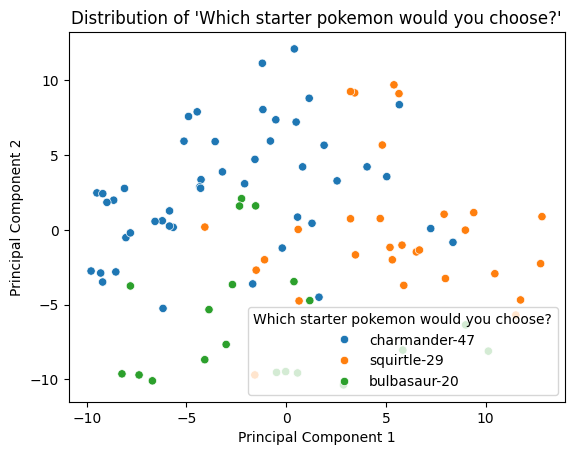

In [29]:
current_question = "seating_question_2"
signify = question_significance[current_question]
pca_df[signify] = list(filtered_df[current_question])
value_counts = pca_df[signify].value_counts()
pca_df[signify] = pca_df[signify].apply(update_values(value_counts))
# Create a scatter plot using Seaborn
sns.scatterplot(x='PC1', y='PC2', data=pca_df, hue = signify)
plt.title(f"Distribution of '{signify}'")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

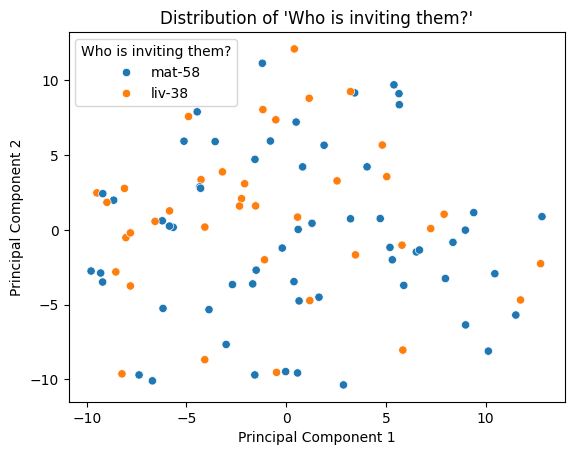

In [30]:
current_question = "friend_of"
signify = question_significance[current_question]
pca_df[signify] = list(filtered_df[current_question])
value_counts = pca_df[signify].value_counts()
pca_df[signify] = pca_df[signify].apply(update_values(value_counts))
# Create a scatter plot using Seaborn
sns.scatterplot(x='PC1', y='PC2', data=pca_df, hue = signify)
plt.title(f"Distribution of '{signify}'")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

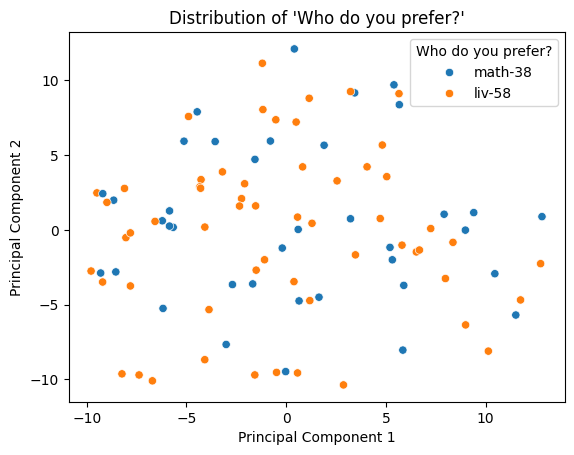

In [31]:
current_question = "seating_question_10"
signify = question_significance[current_question]
pca_df[signify] = list(filtered_df[current_question])
value_counts = pca_df[signify].value_counts()
pca_df[signify] = pca_df[signify].apply(update_values(value_counts))
# Create a scatter plot using Seaborn
sns.scatterplot(x='PC1', y='PC2', data=pca_df, hue = signify)
plt.title(f"Distribution of '{signify}'")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Run UMAP

In [32]:
# Run UMAP
reducer = umap.UMAP(n_components=2)
embedding = reducer.fit_transform(one_hot_encoded)

In [33]:
# Create a new DataFrame to store the principal components
umap_df = pd.DataFrame(data=embedding, columns=['dim1', 'dim2'])

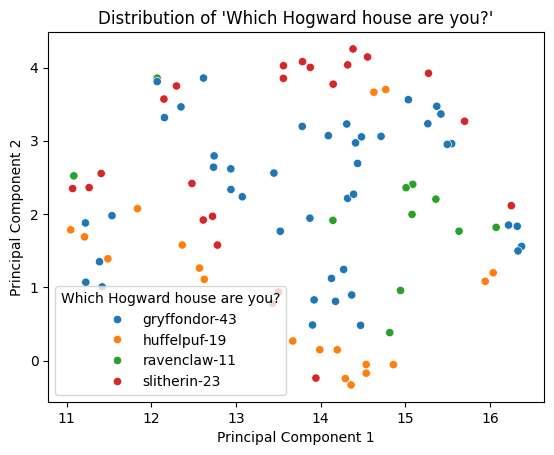

In [34]:
current_question = "seating_question_3"
signify = question_significance[current_question]
umap_df[signify] = list(filtered_df[current_question])
value_counts = umap_df[signify].value_counts()
umap_df[signify] = umap_df[signify].apply(update_values(value_counts))
# Create a scatter plot using Seaborn
sns.scatterplot(x='dim1', y='dim2', data=umap_df, hue = signify)
plt.title(f"Distribution of '{signify}'")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [35]:
# Define the cluster sizes
cluster_sizes = [12, 15, 32, 6, 21]

# Initialize KMeans with the desired number of clusters
kmeans = KMeans(n_clusters=len(cluster_sizes))

# Fit KMeans to the UMAP-transformed data
clusters = kmeans.fit_predict(embedding)

# Assign each data point to a cluster
cluster_assignments = []
start = 0
for size in cluster_sizes:
    end = start + size
    cluster_assignments.append(clusters[start:end])
    start = end


/home/mat2m10/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [36]:
# Extract cluster labels
cluster_labels = kmeans.labels_
cluster_labels

array([0, 2, 1, 4, 1, 2, 3, 2, 1, 2, 4, 1, 2, 3, 1, 0, 0, 2, 3, 4, 3, 2,
       4, 2, 3, 1, 1, 4, 3, 1, 0, 2, 0, 3, 1, 0, 1, 4, 2, 1, 4, 3, 0, 1,
       4, 3, 4, 1, 0, 4, 0, 2, 0, 4, 2, 0, 1, 0, 2, 2, 0, 0, 1, 2, 4, 3,
       2, 3, 2, 3, 1, 0, 1, 0, 1, 0, 0, 3, 1, 0, 0, 1, 2, 0, 0, 1, 4, 1,
       0, 3, 1, 4, 3, 0, 0, 2], dtype=int32)

In [37]:
umap_df['tabels'] = cluster_labels

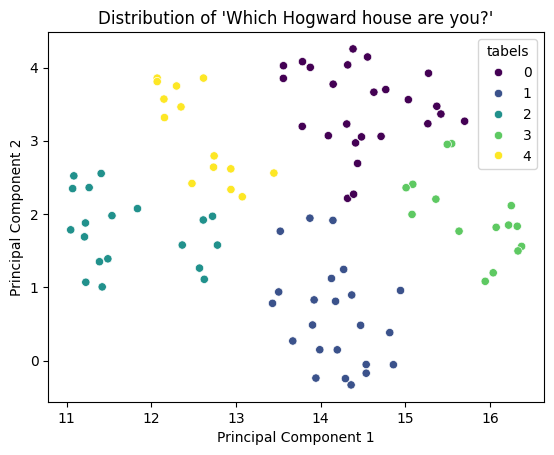

In [38]:
sns.scatterplot(x='dim1', y='dim2', data=umap_df, hue = 'tabels',palette = 'viridis')
plt.title(f"Distribution of '{signify}'")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Groups of males and females

In [39]:
umap_df = umap_df[['dim1','dim2','tabels']]
umap_df['gender'] = list(needed_later['Sex'])
umap_df['email'] = list(needed_later['email'])

In [40]:
# Assuming umap_df is your DataFrame with columns 'dim1', 'dim2', and 'gender'
male_df = umap_df[umap_df['gender'] == 'male']
female_df = umap_df[umap_df['gender'] == 'female']

# Compute pairwise distances between male and female samples
distances = cdist(male_df[['dim1', 'dim2']], female_df[['dim1', 'dim2']])

# Find the closest male-female pairs
min_indices = distances.argmin(axis=1)
closest_pairs = [(male_df.iloc[i], female_df.iloc[j]) for i, j in enumerate(min_indices)]

# Create a DataFrame with the closest pairs
closest_pairs_df = pd.DataFrame(closest_pairs, columns=['Male', 'Female'])


In [90]:
pair = closest_pairs_df.iloc[0]
male = pair['Male']
female = pair['Female']
match = pd.concat([pd.DataFrame(data=male),pd.DataFrame(data=female)],axis=1)
first_db = needed_later[['email','name','family_name']]
first_merge = pd.merge(first_db, match.T[['dim1','dim2','email']], on='email', how='inner')
values_array = [value for value in question_significance.values()]
third_db = needed_later[["friend_of","seating_question_1","seating_question_2","seating_question_3","seating_question_4","seating_question_5","seating_question_6","seating_question_7","seating_question_8","seating_question_9","seating_question_10"]]
# Create a dictionary mapping old column names to new column names
column_mapping = dict(zip(third_db.columns, values_array))

# Rename columns using the dictionary
third_db.rename(columns=column_mapping, inplace=True)
third_db = third_db.applymap(lambda x: str(x).split('_')[-1])
third_db.replace(r'^\s*$', "no answer", regex=True, inplace=True)
third_db['email'] = list(needed_later['email'])
last_merge = pd.merge(first_merge, third_db, on='email', how='inner')
last_merge

/tmp/ipykernel_22417/4076693006.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  third_db.rename(columns=column_mapping, inplace=True)
/tmp/ipykernel_22417/4076693006.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  third_db = third_db.applymap(lambda x: str(x).split('_')[-1])


,email,name,family_name,dim1,dim2,Who is inviting them?,Salt or Paprika?,Which starter pokemon would you choose?,Which Hogward house are you?,Ideal friday evening?,What's your favorite drink?,What is most likely to exist?,What is the best aroma?,What where we talking about?,What is your favoured language?,Who do you prefer?
0,pietdel@gmail.com,Pierre,Delacroix,14.713353,3.060441,mat,paprika,charmander,gryffondor,browncafe,wine,aliens,pepper,spices,france,math
1,poli.camilla@gmail.com,Camilla,Poli,14.481974,3.053364,mat,salt,charmander,gryffondor,browncafe,wine,aliens,chocolate,spices,unitedkingdom,math
